In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
import statsmodels.api as sm
from tools import *
import warnings

In [18]:
warnings.simplefilter("ignore")

In [19]:
data = pd.read_csv("../data/smoking.csv")
data.drop(["ID", "oral"], axis=1, inplace=True)
data.head()

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,Y,0
1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,Y,0
2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,N,1
3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,Y,0
4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,N,0


In [20]:
#Compressing hearing and eyesight columns for both ears/eyes into one.
data["eyesight"] = (data["eyesight(left)"] + data["eyesight(right)"])/2.0
data["hearing"] = (data["hearing(left)"] + data["hearing(right)"])/2.0
data.drop(['eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)'], axis = 1, inplace = True)

In [21]:
oe = OrdinalEncoder()
categorical_cols = data.select_dtypes(include='object').columns.tolist()
data[categorical_cols] = oe.fit_transform(data[data.select_dtypes(include='object').columns.tolist()]) 
oe.categories_

[array(['F', 'M'], dtype=object), array(['N', 'Y'], dtype=object)]

In [22]:
y = data["smoking"].copy()
X = data.drop("smoking", axis=1).copy()
X.drop(['Urine protein', 'dental caries', 'tartar', 'hearing'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

## Model I

In [23]:
rf_I = RandomForestClassifier(criterion= 'entropy', n_estimators= 1000,n_jobs=-1)
rf_I.fit(X_train, y_train)
model_I = generate_raport(rf_I, X_train, X_test, y_train, y_test, True)
model_I["Name"]= "Random Forest"
model_I

,Precision,Recall,F1 Score,Accuracy,Roc_auc_score,Name
0,0.756522,0.803988,0.779533,0.832121,0.916984,Random Forest


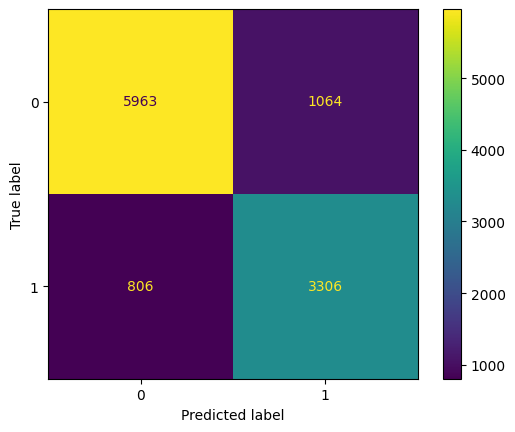

In [24]:
plot_confusion_matrix(rf_I, X_test, y_test)

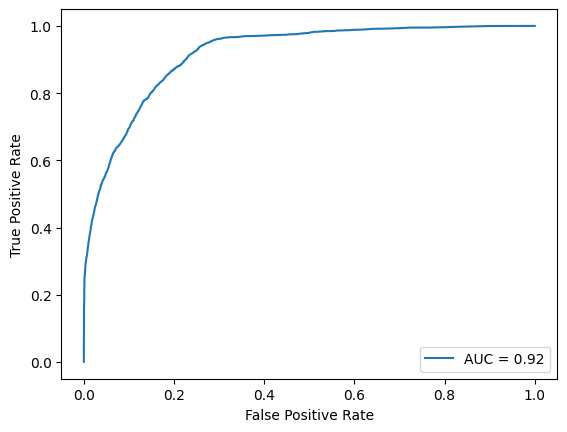

In [25]:
plot_roc_auc(rf_I, X_test, y_test).plot()

## Cross Validation

In [26]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.3f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

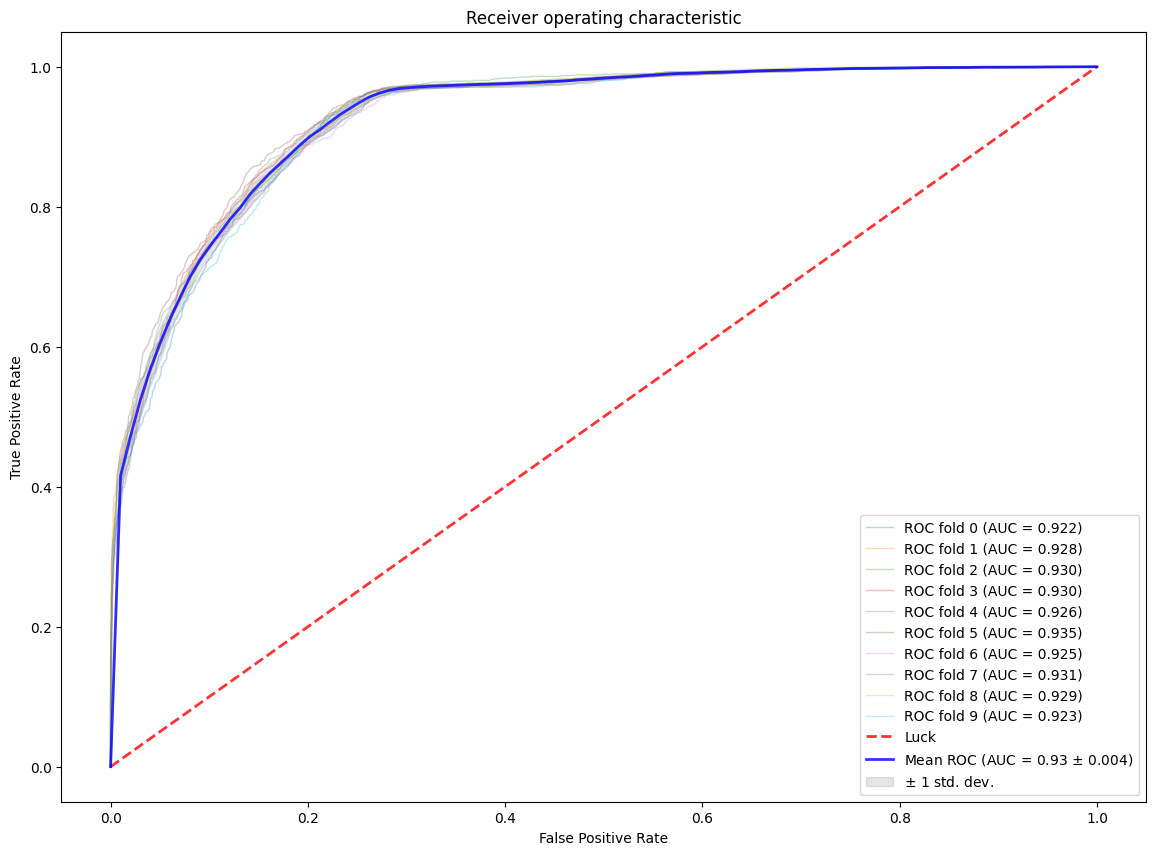

,AUC Train,AUC Test
0,1.0,0.922213
1,1.0,0.927982
2,1.0,0.930461
3,1.0,0.929938
4,1.0,0.926136
5,1.0,0.935167
6,1.0,0.924765
7,1.0,0.931309
8,1.0,0.928513
9,1.0,0.923151


In [27]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
clf = rf_I
for (train, test), i in zip(cv.split(X, y), range(10)):
    rf_I.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [28]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

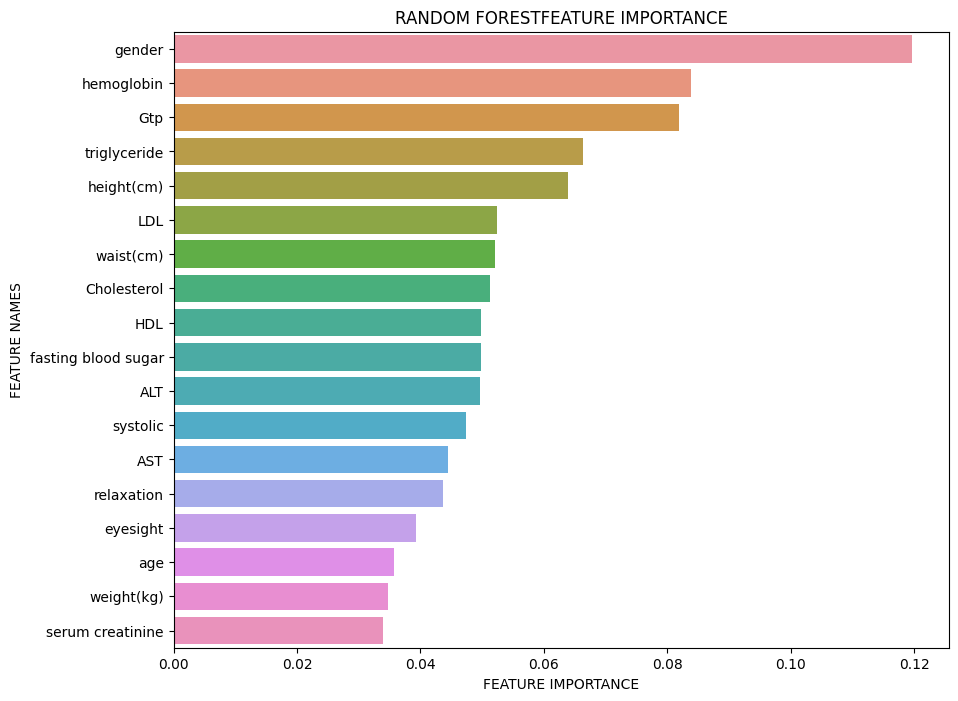

In [29]:
plot_feature_importance(rf_I.feature_importances_,X_train.columns,'RANDOM FOREST')

In [30]:
# modelRF = RandomForestClassifier(n_jobs=-1)
# # defining parameter range
# # parameters = { 'criterion': ['gini', 'entropy'],
# #               'n_estimators' : [ 250, 500, 1000]}
 
# parameters = {
#     'criterion' : ['gini', 'entropy'],
#     'n_estimators' : [500, 1000]
# }
# from sklearn.model_selection import GridSearchCV
# grid = GridSearchCV(
#     modelRF,
#     parameters,
#     refit = True,
#     cv = 10,
#     verbose = 3,
#     n_jobs=-1)
 
# # fitting the model for grid search
# model = grid.fit(X_train, y_train)
# print('Best parameters for Random Forest Model:', grid.best_params_)